In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import obspy

from obspy.core.util import AttribDict
from obspy.imaging.cm import obspy_sequential
from obspy.signal.invsim import corn_freq_2_paz
from obspy.signal.array_analysis import array_processing

from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

# import data, preprocess...

In [3]:
st=obspy.Stream([trZ_SYBOB,trZ_SYB01,trZ_SYB02,trZ_SYB03])

NameError: name 'trZ_SYBOB' is not defined

In [4]:
#set coordinates
st[0].stats.coordinates = AttribDict({
    'latitude': 48.120943,
    'elevation': 516.8,
    'longitude': 11.569422})

st[1].stats.coordinates = AttribDict({
    'latitude': 48.120018,
    'elevation': 515.0,
    'longitude': 11.569354})

st[2].stats.coordinates = AttribDict({
    'latitude': 48.120553,
    'elevation': 516.8,
    'longitude': 11.568053})

st[3].stats.coordinates = AttribDict({
    'latitude': 48.119531,
    'elevation': 515.0,
    'longitude': 11.565401})

NameError: name 'st' is not defined

In [15]:
#beamforming
kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, Slow Step
    sll_x=-3.0, slm_x=3.0, sll_y=-3.0, slm_y=3.0, sl_s=0.05,
    # sliding window properties
    win_len=5.0, win_frac=0.2,
    # frequency properties
    frqlow=1.0, frqhigh=20.0, prewhiten=0,
    # restrict output
    semb_thres=-1e9, vel_thres=-1e9, timestamp='mlabday',
    stime=t1+5, etime=t2-5
)

In [16]:
out = array_processing(st, **kwargs)

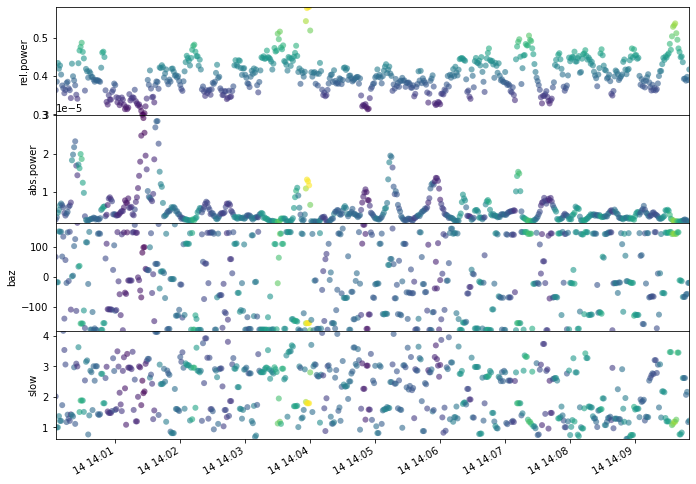

In [17]:
# Plot
labels = ['rel.power', 'abs.power', 'baz', 'slow']

xlocator = mdates.AutoDateLocator()
fig = plt.figure(figsize=(11,8))
for i, lab in enumerate(labels):
    ax = fig.add_subplot(4, 1, i + 1)
    ax.scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6,
               edgecolors='none', cmap=obspy_sequential)
    ax.set_ylabel(lab)
    ax.set_xlim(out[0, 0], out[-1, 0])
    ax.set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
    ax.xaxis.set_major_locator(xlocator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))


fig.autofmt_xdate()
fig.subplots_adjust(left=0.15, top=0.95, right=0.95, bottom=0.2, hspace=0)
plt.show()

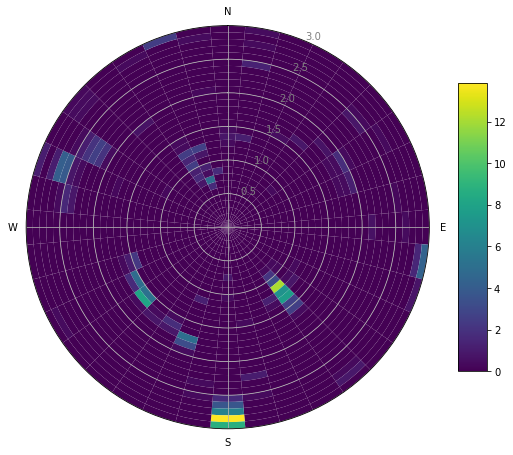

In [18]:
# Plot

cmap = obspy_sequential

# make output human readable, adjust backazimuth to values between 0 and 360
t, rel_power, abs_power, baz, slow = out.T
baz[baz < 0.0] += 360

# choose number of fractions in plot (desirably 360 degree/N is an integer!)
N = 36
N2 = 30
abins = np.arange(N + 1) * 360. / N
sbins = np.linspace(0, 3, N2 + 1)


# sum rel power in bins given by abins and sbins
hist, baz_edges, sl_edges = \
    np.histogram2d(baz, slow, bins=[abins, sbins], weights=rel_power)

# transform to radian
baz_edges = np.radians(baz_edges)

# add polar and colorbar axes
fig = plt.figure(figsize=(8, 8))
cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

dh = abs(sl_edges[1] - sl_edges[0])
dw = abs(baz_edges[1] - baz_edges[0])

# circle through backazimuth
for i, row in enumerate(hist):
    bars = ax.bar((i * dw) * np.ones(N2),
                  height=dh * np.ones(N2),
                  width=dw, bottom=dh * np.arange(N2),
                  color=cmap(row / hist.max()))

ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
ax.set_xticklabels(['N', 'E', 'S', 'W'])

# set slowness limits
ax.set_ylim(0, 3)
[i.set_color('grey') for i in ax.get_yticklabels()]
ColorbarBase(cax, cmap=cmap,
             norm=Normalize(vmin=hist.min(), vmax=hist.max()))

plt.show()